In [1]:
# Importing libraries
import pandas as pd
from preprocessing_utils import  get_class_names, get_policies, get_datasets, transform_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, predict_model, load_model, plot_roc_curve
from torchsummary import summary
import torchvision.models as models

# Enable the widgets extension for JupyterLab
%pip install jupyterlab_widgets
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Check if CUDA is available
print(torch.__version__)  
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1+cu121
12.1
90100
True


### Define Global variables

In [3]:
# Global variables

# Define the class names for the medical conditions
class_names = get_class_names()

# Define the policies for dataset preparation
policies = get_policies()

# Path to the zip file
zip_path = "./chexpert.zip"

# Path to the directory where the datasets will be extracted
data_dir = "./CheXpert-v1.0-small"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the batch size
batch_size = 16

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

### Download dataset from Kaggle

In [4]:
import os
import shutil
import subprocess


# Check if the dataset is already downloaded, if not download it
if not os.path.exists(zip_path):
    print("Downloading the dataset...")
    # Check if kaggle is installed
    try:
        subprocess.run(["kaggle", "--version"], check=True)
        print("Kaggle is already installed.")
    except subprocess.CalledProcessError:
        print("Kaggle is not installed. Installing kaggle...")
        %pip install kaggle

    # Check if the file already exists in the destination
    kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
    if not os.path.exists('kaggle.json') and not os.path.exists(kaggle_json_path):
        # Move kaggle.json to ~/.kaggle
        os.makedirs(os.path.dirname(kaggle_json_path), exist_ok=True)
        shutil.move('kaggle.json', kaggle_json_path)
        # Set permissions
        os.chmod(kaggle_json_path, 0o600)
    else:
        print("kaggle.json already exists in the destination.")

    # Download the dataset
    subprocess.run(["kaggle", "datasets", "download", "-d", "ashery/chexpert"], check=True)
else:
    print("Dataset already downloaded.")

Dataset already downloaded.


### Extract the zip file to improve performance

In [5]:
import zipfile

# Check if the dataset is already extracted, if not extract it
if not os.path.exists(data_dir):
    print("Extracting the dataset...")
    #unzip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    #list files in the extracted dir
    os.listdir(data_dir)
else:
    print("Dataset already extracted.")

Dataset already extracted.


### Load train, validtion and test datasets

In [6]:
# Load the datasets
train_df, validation_df, test_df = get_datasets(zip_path)

if train_df is None or validation_df is None or test_df is None:
    print("Error loading the datasets.")
else:
    print("Datasets loaded successfully.")

in original_train_df Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
in dataframe Count for each class:
Pleural Effusion
 1.0    86187
 0.0    35396
-1.0    11628
Name: count, dtype: int64
in dataset_df (only Frontal) Count for each class:
Pleural Effusion
 1.0    76899
 0.0    25299
-1.0     9578
Name: count, dtype: int64
in y_df Count for each class:
Pleural Effusion
 1.0                76899
 0.0                25299
-1.0                 9578
Name: count, dtype: int64
in y (labels) Count for each class:
1    86477
0    25299
Name: count, dtype: int64
in dataframe Count for each class:
Pleural Effusion
0.0    167
1.0     67
Name: count, dtype: int64
in dataset_df (only Frontal) Count for each class:
Pleural Effusion
0.0    138
1.0     64
Name: count, dtype: int64
in y_df Count for each class:
Pleural Effusion
0.0                 138
1.0                  64
Name: count, dtype: int64
in y (labels) Count for each class:
0    138

#### Peak into training dataset

In [7]:
# Print some information about the train DataFrame
display(train_df.head())
print("Number of rows and columns in the train DataFrame:", train_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(train_df.dtypes)

# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = train_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient16646/study1/...,1
1,CheXpert-v1.0-small/train/patient10056/study9/...,1
2,CheXpert-v1.0-small/train/patient42372/study4/...,1
3,CheXpert-v1.0-small/train/patient45046/study5/...,1
4,CheXpert-v1.0-small/train/patient05198/study2/...,0


Number of rows and columns in the train DataFrame: (89420, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object
Count for each class:
Pleural Effusion
1    69302
0    20118
Name: count, dtype: int64


### Peak into the validation dataset

In [8]:
# Print some information about the validtion DataFrame
# Set pandas display options to show all columns
display(validation_df.head())
print("Number of rows and columns in the validation DataFrame:", validation_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(validation_df.dtypes)

# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = validation_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/train/patient48924/study2/...,1
1,CheXpert-v1.0-small/train/patient38687/study1/...,1
2,CheXpert-v1.0-small/train/patient03187/study2/...,1
3,CheXpert-v1.0-small/train/patient37033/study15...,1
4,CheXpert-v1.0-small/train/patient25492/study1/...,0


Number of rows and columns in the validation DataFrame: (22356, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object
Count for each class:
Pleural Effusion
1    17175
0     5181
Name: count, dtype: int64


#### Peak into the test dataset

In [9]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
display(test_df.head())
print("Number of rows and columns in the test DataFrame:", test_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(test_df.dtypes)


# Count the occurrences of each unique value in the "Pleural Effusion" column
pleural_effusion_counts = test_df['Pleural Effusion'].value_counts()

# Print the counts for each class
print(f"Count for each class:\n{pleural_effusion_counts}")

,path,Pleural Effusion
0,CheXpert-v1.0-small/valid/patient64541/study1/...,0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,0
2,CheXpert-v1.0-small/valid/patient64543/study1/...,0
3,CheXpert-v1.0-small/valid/patient64544/study1/...,0
4,CheXpert-v1.0-small/valid/patient64545/study1/...,1


Number of rows and columns in the test DataFrame: (202, 2)
Column names and data types:
path                object
Pleural Effusion     int32
dtype: object
Count for each class:
Pleural Effusion
0    138
1     64
Name: count, dtype: int64


#### Dataset formation according to torch (using dataloaders)

In [10]:
# Transform the training dataset
train_dataset, train_loader, train_images, train_labels = transform_dataset(train_df, zip_path, batch_size=batch_size, shuffle=True, augment=True)

# Transform the validation dataset
validtion_dataset, validtion_loader, validtion_images, validtion_labels = transform_dataset(validation_df, zip_path, batch_size=batch_size, shuffle=False, augment=False)

# Transform the test dataset
test_dataset, test_loader, test_images, test_labels = transform_dataset(test_df, zip_path, batch_size=batch_size, shuffle=False, augment=False)

#### Visualising example

Original shape: torch.Size([1, 224, 224]), New shape: (224, 224, 1)
Example image:


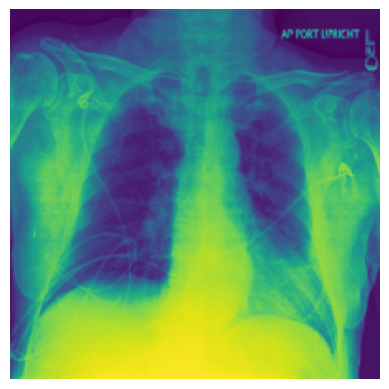

In [11]:
# Select the first image in the batch
image = test_images[0]
original_shape = image.shape
image = image.permute(1, 2, 0).numpy()  # Change shape to (224, 224)
new_shape = image.shape
print(f"Original shape: {original_shape}, New shape: {new_shape}")
# Check the shape of the image to ensure it is (224, 224, 3)
assert new_shape == (224, 224, 1), f"Expected shape (224, 224), but got {image.shape}"

# Denormalize the image for visualization
image = (image * 0.5) + 0.5

# Plot the image
print("Example image:")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

#### Here we can extract different pre-trained models

### Train Stacked Models

In [12]:
from StackedModel import upload_stacked_models

model = upload_stacked_models(n_labels=len(class_names), freeze_layers=True)

# Move the model to the appropriate device
model.to(device)

model_name = "stacked_model"

c:\Users\bar24\anaconda3\envs\ExplainableAI\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bar24\anaconda3\envs\ExplainableAI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\bar24\anaconda3\envs\ExplainableAI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You ca

### Train Densenet169

In [13]:
# from training_utils import upload_pretrained_densenet169

# # Load a pre-trained DenseNet169 model, add custom layers, and freeze certain layers
# # 
# # Parameters:
# # - pretrained: Use a pre-trained version of DenseNet169
# # - add_layers: Add custom layers to the model
# # - n_labels: Number of output labels (classes)
# # - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training
# denseNet169 = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
# model = upload_pretrained_densenet169(denseNet169, add_layers=True, n_labels=len(class_names), freeze_layers=True)

# # Move the model to the appropriate device
# model.to(device)

# model_name = "densenet169"

#### Summary of Model

In [15]:
summary(model, input_size=(1, 224, 224))

Layer (type:depth-idx)                        Param #
├─MobileNetV2: 1-1                            --
|    └─Sequential: 2-1                        --
|    |    └─Conv2d: 3-1                       (288)
|    |    └─InvertedResidual: 3-2             (896)
|    |    └─InvertedResidual: 3-3             (5,136)
|    |    └─InvertedResidual: 3-4             (8,832)
|    |    └─InvertedResidual: 3-5             (10,000)
|    |    └─InvertedResidual: 3-6             (14,848)
|    |    └─InvertedResidual: 3-7             (14,848)
|    |    └─InvertedResidual: 3-8             (21,056)
|    |    └─InvertedResidual: 3-9             (54,272)
|    |    └─InvertedResidual: 3-10            (54,272)
|    |    └─InvertedResidual: 3-11            (54,272)
|    |    └─InvertedResidual: 3-12            (66,624)
|    |    └─InvertedResidual: 3-13            (118,272)
|    |    └─InvertedResidual: 3-14            (118,272)
|    |    └─InvertedResidual: 3-15            (155,264)
|    |    └─InvertedResidual

Layer (type:depth-idx)                        Param #
├─MobileNetV2: 1-1                            --
|    └─Sequential: 2-1                        --
|    |    └─Conv2d: 3-1                       (288)
|    |    └─InvertedResidual: 3-2             (896)
|    |    └─InvertedResidual: 3-3             (5,136)
|    |    └─InvertedResidual: 3-4             (8,832)
|    |    └─InvertedResidual: 3-5             (10,000)
|    |    └─InvertedResidual: 3-6             (14,848)
|    |    └─InvertedResidual: 3-7             (14,848)
|    |    └─InvertedResidual: 3-8             (21,056)
|    |    └─InvertedResidual: 3-9             (54,272)
|    |    └─InvertedResidual: 3-10            (54,272)
|    |    └─InvertedResidual: 3-11            (54,272)
|    |    └─InvertedResidual: 3-12            (66,624)
|    |    └─InvertedResidual: 3-13            (118,272)
|    |    └─InvertedResidual: 3-14            (118,272)
|    |    └─InvertedResidual: 3-15            (155,264)
|    |    └─InvertedResidual

#### Here is how we train the model

Training stacked_model model for 25 epochs


c:\Users\bar24\anaconda3\envs\ExplainableAI\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 1/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [1/25], Train Loss: 0.3914, Train Accuracy: 0.7776, Test Loss: 0.3834, Test Accuracy: 0.7730, Test AUC: 0.8657


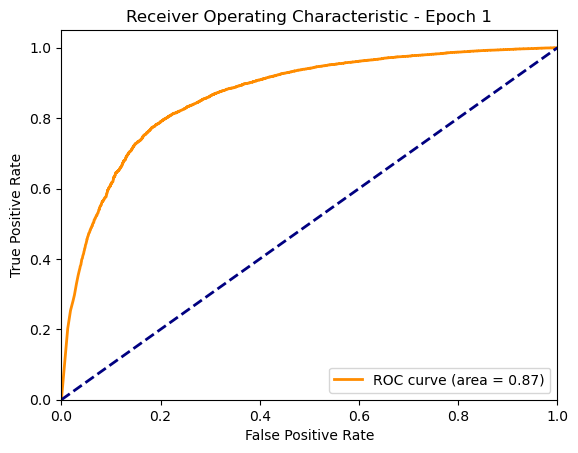

Saved new best model for epoch 1 for model stacked_model


Epoch 2/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 2/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [2/25], Train Loss: 0.3844, Train Accuracy: 0.7936, Test Loss: 0.3844, Test Accuracy: 0.7958, Test AUC: 0.8664


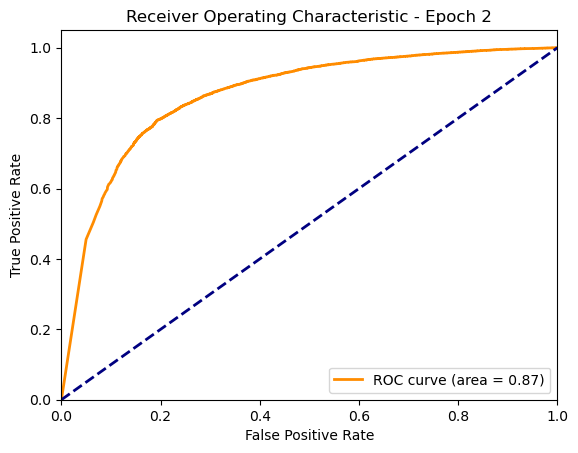

Epoch 3/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 3/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [3/25], Train Loss: 0.3843, Train Accuracy: 0.8104, Test Loss: 0.3811, Test Accuracy: 0.8248, Test AUC: 0.8700


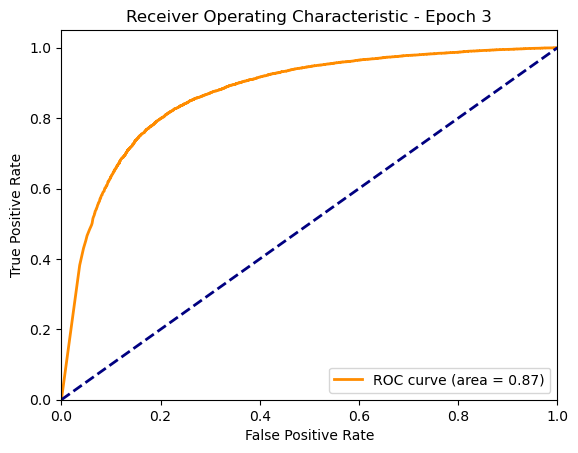

Saved new best model for epoch 3 for model stacked_model


Epoch 4/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 4/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [4/25], Train Loss: 0.3836, Train Accuracy: 0.8145, Test Loss: 0.3813, Test Accuracy: 0.8304, Test AUC: 0.8713


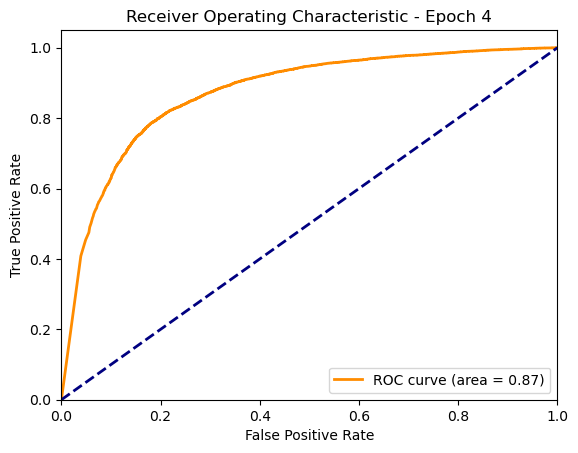

Epoch 5/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 5/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [5/25], Train Loss: 0.3825, Train Accuracy: 0.8182, Test Loss: 0.3800, Test Accuracy: 0.8314, Test AUC: 0.8744


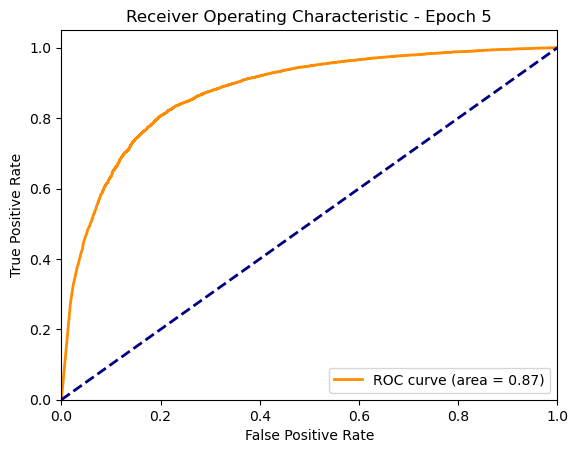

Saved new best model for epoch 5 for model stacked_model


Epoch 6/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 6/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [6/25], Train Loss: 0.3821, Train Accuracy: 0.8233, Test Loss: 0.3815, Test Accuracy: 0.8462, Test AUC: 0.8724


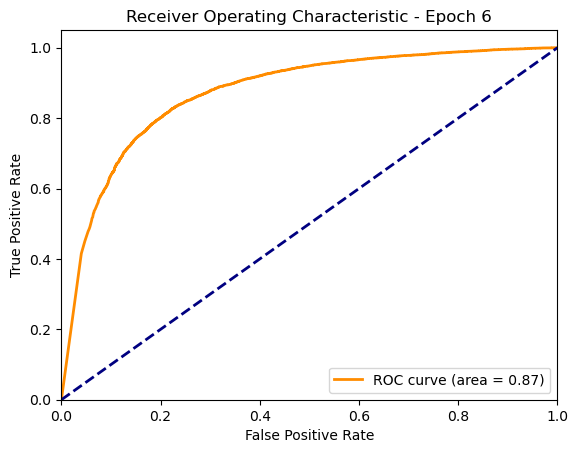

Epoch 7/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 7/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [7/25], Train Loss: 0.3820, Train Accuracy: 0.8201, Test Loss: 0.3804, Test Accuracy: 0.8321, Test AUC: 0.8722


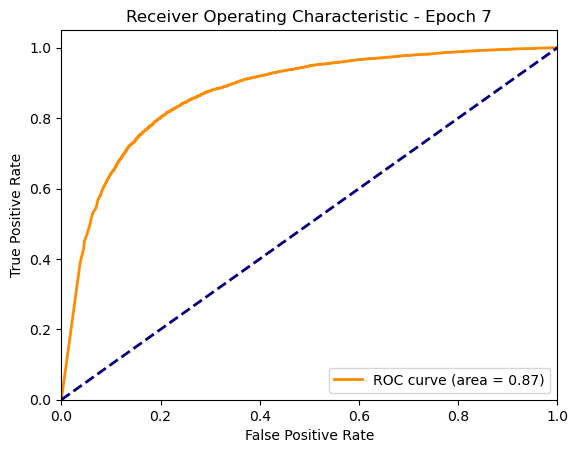

Epoch 8/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 8/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [8/25], Train Loss: 0.3815, Train Accuracy: 0.8274, Test Loss: 0.3820, Test Accuracy: 0.8466, Test AUC: 0.8746


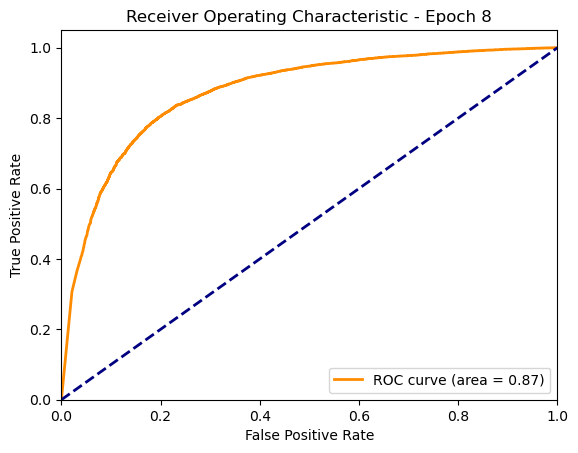

Epoch 9/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 9/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [9/25], Train Loss: 0.3815, Train Accuracy: 0.8268, Test Loss: 0.3801, Test Accuracy: 0.8362, Test AUC: 0.8709


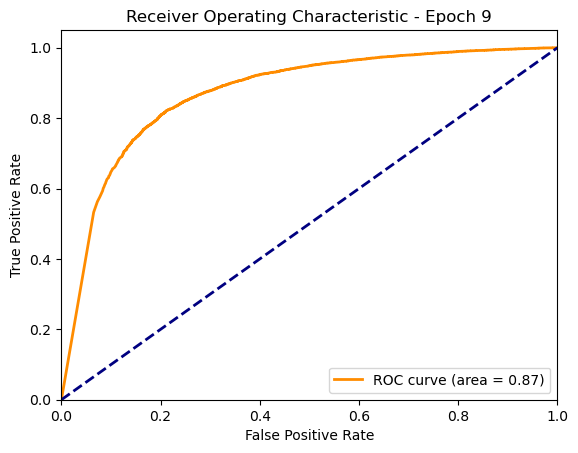

Epoch 10/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 10/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [10/25], Train Loss: 0.3809, Train Accuracy: 0.8273, Test Loss: 0.3798, Test Accuracy: 0.8370, Test AUC: 0.8708


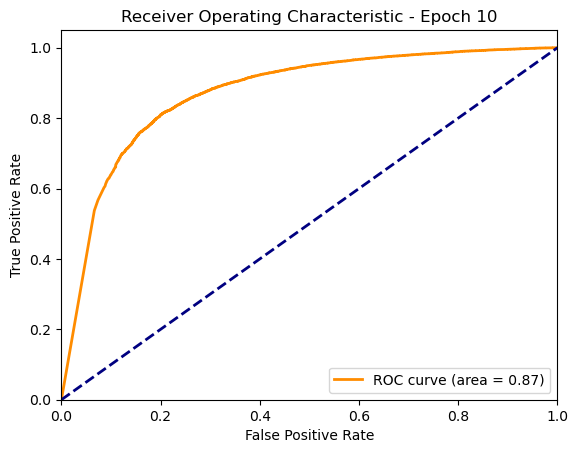

Saved new best model for epoch 10 for model stacked_model


Epoch 11/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 11/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [11/25], Train Loss: 0.3816, Train Accuracy: 0.8286, Test Loss: 0.3801, Test Accuracy: 0.8456, Test AUC: 0.8720


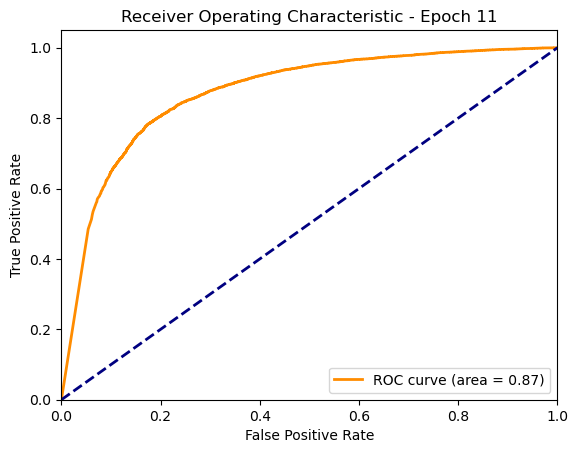

Epoch 12/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 12/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [12/25], Train Loss: 0.3804, Train Accuracy: 0.8327, Test Loss: 0.3887, Test Accuracy: 0.8410, Test AUC: 0.8739


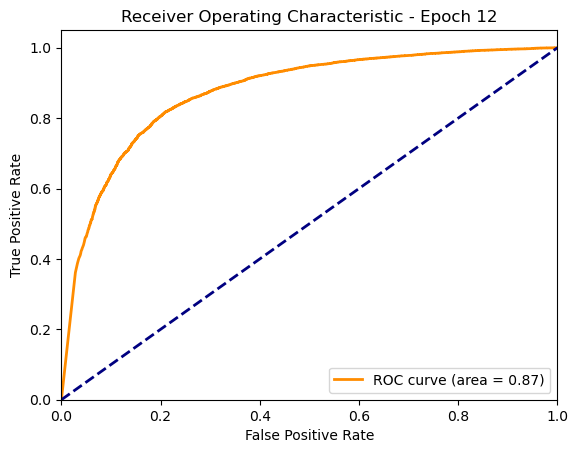

Epoch 13/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 13/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [13/25], Train Loss: 0.3808, Train Accuracy: 0.8281, Test Loss: 0.3800, Test Accuracy: 0.8476, Test AUC: 0.8721


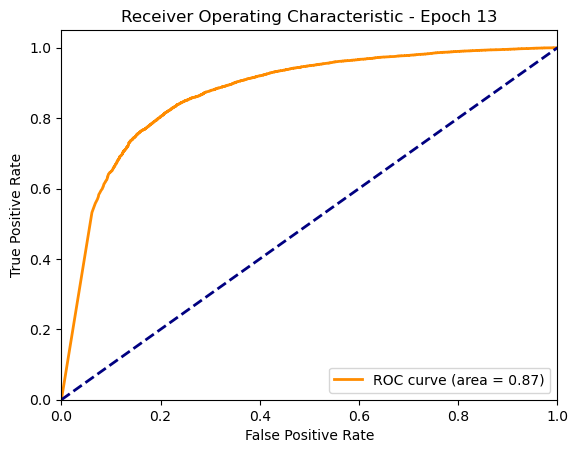

Epoch 14/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 14/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [14/25], Train Loss: 0.3800, Train Accuracy: 0.8340, Test Loss: 0.3796, Test Accuracy: 0.8464, Test AUC: 0.8746


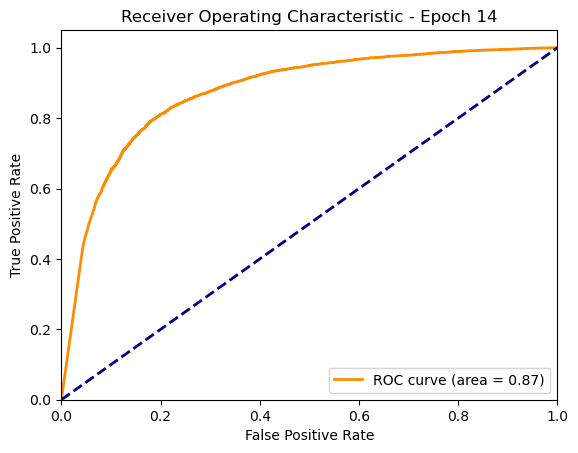

Saved new best model for epoch 14 for model stacked_model


Epoch 15/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 15/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [15/25], Train Loss: 0.3806, Train Accuracy: 0.8342, Test Loss: 0.3796, Test Accuracy: 0.8429, Test AUC: 0.8699


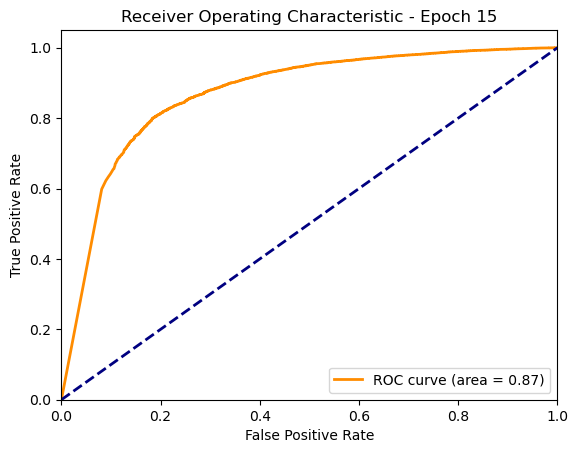

Saved new best model for epoch 15 for model stacked_model


Epoch 16/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 16/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [16/25], Train Loss: 0.3799, Train Accuracy: 0.8323, Test Loss: 0.3796, Test Accuracy: 0.8421, Test AUC: 0.8720


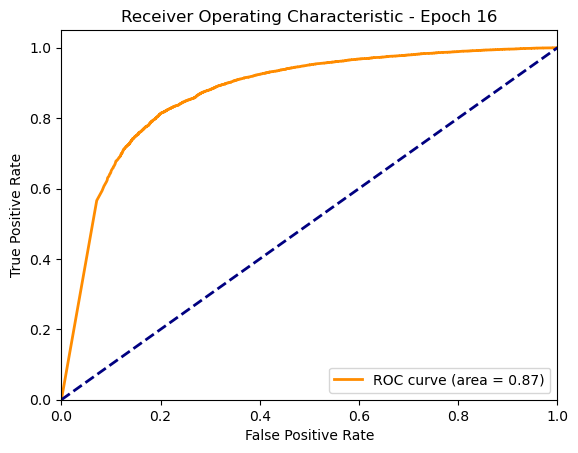

Saved new best model for epoch 16 for model stacked_model


Epoch 17/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 17/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [17/25], Train Loss: 0.3802, Train Accuracy: 0.8354, Test Loss: 0.3789, Test Accuracy: 0.8492, Test AUC: 0.8729


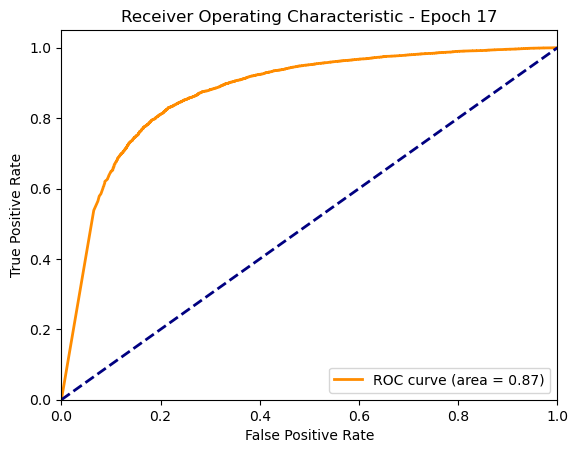

Saved new best model for epoch 17 for model stacked_model


Epoch 18/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 18/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [18/25], Train Loss: 0.3801, Train Accuracy: 0.8368, Test Loss: 0.3791, Test Accuracy: 0.8458, Test AUC: 0.8726


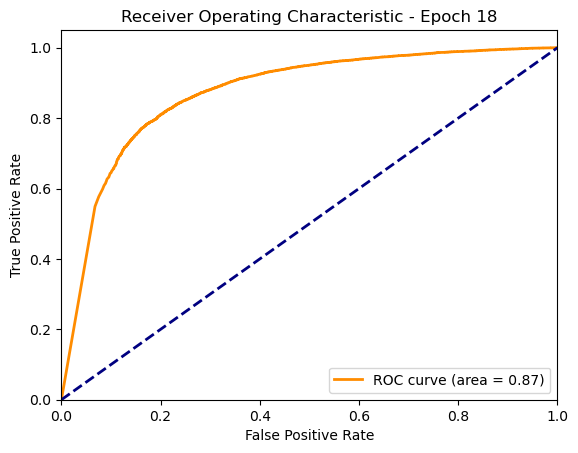

Epoch 19/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 19/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [19/25], Train Loss: 0.3799, Train Accuracy: 0.8368, Test Loss: 0.3817, Test Accuracy: 0.8443, Test AUC: 0.8761


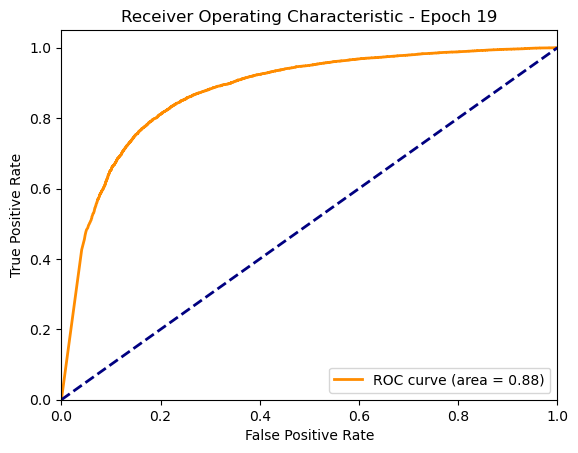

Epoch 20/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 20/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [20/25], Train Loss: 0.3800, Train Accuracy: 0.8346, Test Loss: 0.3794, Test Accuracy: 0.8497, Test AUC: 0.8738


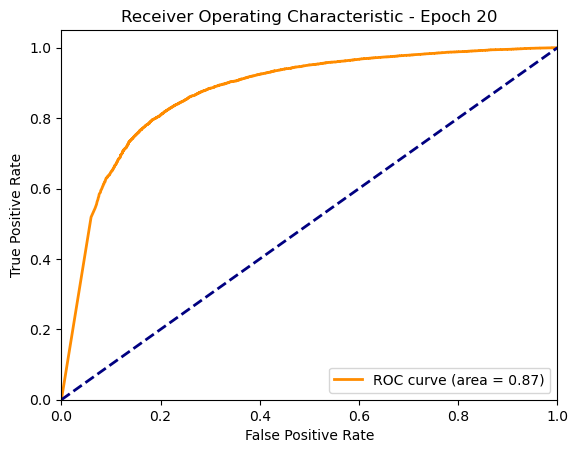

Epoch 21/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 21/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [21/25], Train Loss: 0.3800, Train Accuracy: 0.8323, Test Loss: 0.3792, Test Accuracy: 0.8362, Test AUC: 0.8733


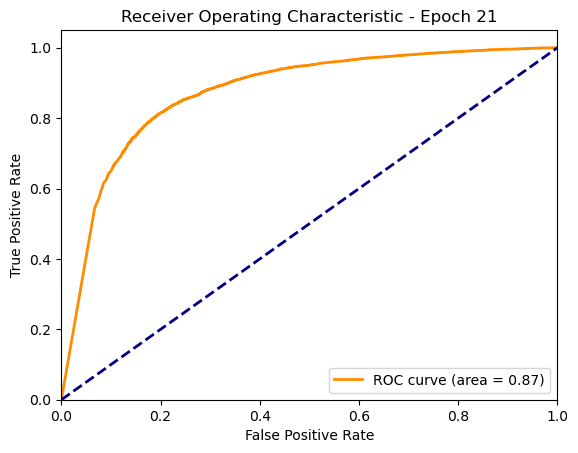

Epoch 22/25 - Training:   0%|          | 0/5589 [00:00<?, ?batch/s]

Epoch 22/25 - Evaluation:   0%|          | 0/1398 [00:00<?, ?batch/s]

Epoch [22/25], Train Loss: 0.3803, Train Accuracy: 0.8319, Test Loss: 0.3792, Test Accuracy: 0.8474, Test AUC: 0.8702


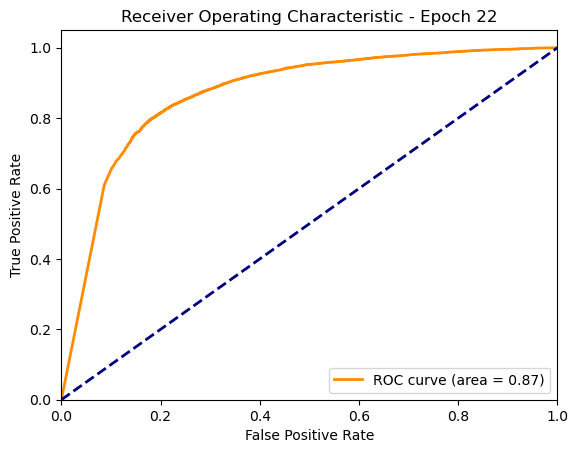

Early stopping at epoch 22 for model stacked_model
Model pickled saved in finetuned_models/stacked_model.pkl
Model pth saved in finetuned_models/stacked_model.pth


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 3, 224, 224] to have 1 channels, but got 3 channels instead

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Calculate class weights to handle class imbalance
# The weight for the positive class (Pleural Effusion = 1) is calculated as:
# total number of samples / (2 * number of positive samples)
# This ensures that the positive class is given more importance during training.
class_weights = torch.tensor([1.0, len(train_df['Pleural Effusion']) / (2 * sum(train_df['Pleural Effusion']))], dtype=torch.float32)

# Define the loss function with class weights
# nn.BCEWithLogitsLoss is used for binary classification tasks.
# pos_weight is used to weight the positive class more heavily.
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])


# Define the loss function
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
# criterion = nn.BCEWithLogitsLoss()

# Define the optimizer with weight decay
# Adam optimizer with learning rate of 0.0001 and weight decay
optimizer_densenet = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer_densenet, mode='min', factor=0.1, patience=5, verbose=True)

# Define the number of epochs
num_epochs = 25

# Train the model
# Parameters:
# - model: The model to be trained (DenseNet169 in this case)
# - train_loader: DataLoader for the training dataset
# - test_loader: DataLoader for the validation dataset
# - criterion: The loss function
# - optimizer: The optimizer
# - num_epochs: Number of epochs to train the model
# - device: Device to train the model on ('cpu' or 'cuda')
# - save_filename: Filename to save the trained model
train_losses, train_accuracies, test_losses, test_accuracies, test_aucs = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=validtion_loader,
    criterion=criterion,
    optimizer=optimizer_densenet,
    scheduler=scheduler,
    num_epochs=num_epochs,
    device=device,
    model_name=model_name
)

# Adjust the learning rate based on the validation loss
for epoch in range(num_epochs):
    # Training and evaluation code here...
    scheduler.step(test_losses[-1])  # Adjust the learning rate based on the latest validation loss

### Evaluate the trained model

In [ ]:
model = load_model(filename="densenet169.pkl", device=device)
test_preds, test_labels = predict_model(model, test_loader, device)
# Plot ROC curve for the test dataset
plot_roc_curve(test_labels, test_preds, model_name='DenseNet169')

In [ ]:
from training_utils import load_model

model = load_model(filename="stacked_model.pkl", device=device)
test_preds, test_labels = predict_model(model, test_loader, device)
# Plot ROC curve for the test dataset
plot_roc_curve(test_labels, test_preds, model_name='Stacked Model')